<a href="https://colab.research.google.com/github/ronyavivi/Deap_learning_assignment3/blob/main/Deap_learning_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3:
Rony Avivi & Avigail shahar

In [279]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

Mount to google drive:

In [280]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's load the data:


In [281]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

# Exploratory Data Analysis:

In [282]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


As we can see, the train contains 70405 dialogues (strings) from "Friends" and "Seinfeld".

Let's check the classes distribution: 

In [283]:
train_df['Show'].value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

Let's look at one example:

In [284]:
train_df.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

## Data preprocessing:

###Cleaning the data:
Let's begin by cleaning the text and removing any HTML leftovers:

In [285]:
from bs4 import BeautifulSoup
import re

# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Apply function on dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(clean_text)
test_df['Dialogue'] = test_df['Dialogue'].apply(clean_text)

In [286]:
train_df.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

In [287]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(remove_special_characters)
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)

In [288]:
train_df.iloc[1, 0]

' to Joey Are you gonna be embarrassed going up there having nothing prepared'

Removing stop words:

In [289]:
import nltk

Let's download all English stop words that NLTK offers and look at a few of them:

In [290]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:5])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We'd like to remove these words from our text. In order to do that we need to create a ToktokTokenizer instace:



In [291]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

Let's see what the tokenizer does:

In [292]:
tokenizer.tokenize(train_df.iloc[1, 0])

['to',
 'Joey',
 'Are',
 'you',
 'gonna',
 'be',
 'embarrassed',
 'going',
 'up',
 'there',
 'having',
 'nothing',
 'prepared']

In [293]:
# Removing the stopwords
from tqdm.notebook import tqdm
tqdm.pandas()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on dialogue column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(remove_stopwords)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [294]:
train_df.iloc[1, 0]

'Joey gonna embarrassed going nothing prepared'

Stemming:

In [295]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_words_list = []
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
# Apply function on dialogue column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(simple_stemmer)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [296]:
train_df.iloc[1, 0]

'joey gonna embarrass go noth prepar'

### Train-test-valdiation split:

In [297]:
X_train = train_df['Dialogue']
Y_train = train_df['Show']
x_test = test_df['Dialogue']
y_test = test_df['Show']

In [298]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=1/16, random_state=1234)

We can also check that the distribution of our labels between test, validation and train is not skewed toward one class:

In [299]:
train_label_count = y_train.value_counts()
test_label_count = y_test.value_counts()
val_label_count = y_val.value_counts()

print('Train Friends to Seinfeld ratio:', train_label_count['Friends'] / train_label_count['Seinfeld'])
print('Validation Friends to Seinfeld ratio:', val_label_count['Friends'] / val_label_count['Seinfeld']) 
print('Test Friends to Seinfeld ratio:', test_label_count['Friends'] / test_label_count['Seinfeld'])

Train Friends to Seinfeld ratio: 1.2487819835780722
Validation Friends to Seinfeld ratio: 1.2431192660550459
Test Friends to Seinfeld ratio: 1.5742874469375379


In [300]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (66004,)
y_train shape: (66004,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (4401,)
y_val shape: (4401,)


###Labeling:
We need to convert the values of 'Friends' and 'Seinfeld' to ones and zeros:

In [301]:
y_train[:5]

56129    Seinfeld
40114     Friends
61139     Friends
35338    Seinfeld
6495     Seinfeld
Name: Show, dtype: object

In [302]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

Let's check that it worked:

In [303]:
y_train[:5]


array([[1],
       [0],
       [0],
       [1],
       [1]])

We can see that now the labels are 'Seinfeld' = 1, 'Friends' = 0.

# Building a DL model:

In [304]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

Let's use Keras' tokenizer and convert to sequences:

In [305]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

In [306]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
x_test_dl = token.texts_to_sequences(x_test)

In [307]:
x_train_dl[0]

[101, 313, 2150, 615, 496, 8784]

Calculate dialogue lengths:

In [308]:
doc_len_list = [len(doc) for doc in x_train_dl]

Longest, shortest, and average dialogue:


In [309]:
max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(185, 0, 5.780816314162778)

Let's examine the distribution:

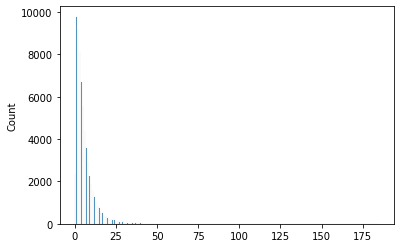

In [310]:
sns.histplot(doc_len_list)

We want to make sure that all sequences have the same length. Because the longest doc isn't that long (185 words), it seems like a reasonable shared value:


In [311]:
from keras.utils import pad_sequences
max_words = 185

x_train_dl = pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = pad_sequences(x_test_dl, maxlen=max_words)

Let's see what a sample look like:



In [312]:
x_train_dl.shape

(66004, 185)

In [313]:
x_train_dl[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [314]:
total_words = len(token.word_index) + 1 
total_words

16984

## Embeddings:
Let's build the architecture:

In [315]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(GRU(4, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 185, 32)           543488    
                                                                 
 conv1d_15 (Conv1D)          (None, 185, 8)            776       
                                                                 
 gru_12 (GRU)                (None, 185, 4)            168       
                                                                 
 flatten_14 (Flatten)        (None, 740)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                47424     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)               

In [316]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
1032/1032 [==============================] - 99s 93ms/step - loss: 0.5371 - accuracy: 0.6944 - val_loss: 0.4938 - val_accuracy: 0.7303
Epoch 2/5
1032/1032 [==============================] - 100s 96ms/step - loss: 0.4379 - accuracy: 0.7713 - val_loss: 0.4962 - val_accuracy: 0.7339
Epoch 3/5
1032/1032 [==============================] - 97s 94ms/step - loss: 0.3891 - accuracy: 0.7967 - val_loss: 0.5264 - val_accuracy: 0.7312
Epoch 4/5
1032/1032 [==============================] - 99s 96ms/step - loss: 0.3494 - accuracy: 0.8184 - val_loss: 0.5576 - val_accuracy: 0.7310
Epoch 5/5
1032/1032 [==============================] - 97s 94ms/step - loss: 0.3152 - accuracy: 0.8364 - val_loss: 0.6084 - val_accuracy: 0.7196


## Model Evaluation : 

Let's evaluate our model on train data :

In [317]:
model.evaluate(x_train_dl, y_train)

2063/2063 [==============================] - 32s 16ms/step - loss: 0.2735 - accuracy: 0.8615


[0.2734886109828949, 0.8615387082099915]

Let's evaluate our model on test data:

In [318]:
model.evaluate(x_test_dl, y_test)

133/133 [==============================] - 2s 16ms/step - loss: 0.5084 - accuracy: 0.8363


[0.5083715915679932, 0.836277961730957]

##Exploring our results:

Let's see all characters in our script : 

In [319]:
characters = test_df['Character'].unique()
print(characters)

['joey' 'monica' 'george' 'kramer' 'rachel' 'ross' 'phoebe' 'jerry'
 'chandler' 'elaine']


prepare the test data and run the test , returns the accuracy

In [320]:
characters_accuracies = {}

In [321]:
def Prepare_and_run_model (test_data,p):  
    x_test = p_test['Dialogue']
    print(f'x_test shape for {p}:', x_test.shape)
    y_test = p_test['Show']
    y_test = lb.transform(y_test)
    x_test_dl = token.texts_to_sequences(x_test)
    x_test_dl = pad_sequences(x_test_dl, maxlen=max_words)
    characters_accuracies[p] = model.evaluate(x_test_dl, y_test)
    return

Let's split the test data to specific characters :

In [322]:
for p in characters : 
    p_test = test_df[test_df['Character'] == p]
    Prepare_and_run_model(p_test,p)

x_test shape for joey: (472,)
15/15 [==============================] - 0s 16ms/step - loss: 0.4783 - accuracy: 0.8559
x_test shape for monica: (382,)
12/12 [==============================] - 0s 17ms/step - loss: 0.3892 - accuracy: 0.8796
x_test shape for george: (474,)
15/15 [==============================] - 0s 16ms/step - loss: 0.5884 - accuracy: 0.7954
x_test shape for kramer: (296,)
10/10 [==============================] - 0s 15ms/step - loss: 0.6410 - accuracy: 0.7905
x_test shape for rachel: (462,)
15/15 [==============================] - 0s 16ms/step - loss: 0.3824 - accuracy: 0.8723
x_test shape for ross: (475,)
15/15 [==============================] - 0s 16ms/step - loss: 0.3853 - accuracy: 0.8716
x_test shape for phoebe: (394,)
13/13 [==============================] - 0s 16ms/step - loss: 0.4223 - accuracy: 0.8934
x_test shape for jerry: (587,)
19/19 [==============================] - 0s 17ms/step - loss: 0.6232 - accuracy: 0.7888
x_test shape for chandler: (411,)
13/13 [====

Let's see our results : 

In [323]:
print (characters_accuracies)

{'joey': [0.47833406925201416, 0.8559321761131287], 'monica': [0.38917386531829834, 0.8795811533927917], 'george': [0.5884103775024414, 0.7953586578369141], 'kramer': [0.6410277485847473, 0.7905405163764954], 'rachel': [0.3824487030506134, 0.8722943663597107], 'ross': [0.38528066873550415, 0.8715789318084717], 'phoebe': [0.42225053906440735, 0.893401026725769], 'jerry': [0.6231834888458252, 0.7887563705444336], 'chandler': [0.5519886612892151, 0.8321167826652527], 'elaine': [0.6719381213188171, 0.7705479264259338]}


# CSV file : 

In [324]:
results = {'Test score (Accuracy)': ['0.8363'],
           'Train score (Accuracy)': ['0.8615'],
           'Number of trainable parameters': ['591,921'],
           'Number of layers': ['7'],
           'Regularization methods': ['GRU, Dropout'],
           'Number of epochs': ['5'],
           'Loss function':['binary_crossentropy'],
           'Optimizer': ['adam'],
           'Embedding dimension' : ['32'],
           }

df = pd.DataFrame(results)
df

,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer,Embedding dimension
0,0.8377,0.8559,"591,921",7,"GRU, Dropout",5,binary_crossentropy,adam,32


In [325]:
import os
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))